In [28]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

False


# Project

Can a computer "learn" to classify artists by their paintings? 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [3]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '19f24dd8e',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': 'C:\\Users\\Mercè\\anaconda3\\Lib\\site-packages\\IPython',
 'ipython_version': '8.20.0',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.22631-SP0',
 'sys_executable': 'c:\\Users\\Mercè\\anaconda3\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, '
                '18:05:47) [MSC v.1916 64 bit (AMD64)]'}


In [4]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5629013240655808165
xla_global_id: -1
]


In [5]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

## Directories

In [6]:
# marta
# DATA_DIR = r"C:\Users\jesus\Desktop\Projecte"
# TRAIN_1_DIR = r"C:\Users\jesus\Desktop\Projecte\train_10_artists\train_10_artists"
#TRAIN_2_DIR = r"C:\Users\jesus\Desktop\Projecte\imatges\train_9\train_9"
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
# TEST_DIR = r"C:\Users\jesus\Desktop\Projecte\test"

# marta azure
# DATA_DIR = '/home/xnmaster/Pictures'
# TRAIN_1_DIR = '/home/xnmaster/Pictures/train_10_artists/train_10_artists'
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
# TEST_DIR = "/home/xnmaster/Pictures/test"

# mercè 
# DATA_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input" 
TRAIN_1_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\train_10_selected_artists\train_10_selected_artists"
TEST_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\test\test"
# TRAIN_1_DIR = "/home/xnmaster/Project/input/train_10_selected_artists"
# TEST_DIR = "/home/xnmaster/Project/input/test"
TRAIN_DIRS = [TRAIN_1_DIR]

# ariadna
# DATA_DIR = "../../"
# TRAIN_1_DIR = "../../train_10_selected_artists"
# TEST_DIR = "../../test"
# TRAIN_DIRS = [TRAIN_1_DIR]

# #Daria
# TRAIN_1_DIR = '../our_code/train_1'
# TEST_DIR = '../our_code/test_1'
# TRAIN_1_ROT_DIR = '../our_code/train_1_rotated'
# TRAIN_DIRS = [TRAIN_1_DIR]


In [6]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 3857
Number of files in the folder TEST_DIR: 6626


In [7]:
# df = pd.read_csv('/home/xnmaster/Pictures/all_data_info.csv') # r'\train_info\train_info.csv'
# df = pd.read_csv('/home/xnmaster/Project/input/all_data_info/all_data_info.csv')
df = pd.read_csv(r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\all_data_info\all_data_info.csv")
# df = pd.read_csv("../all_data_info.csv/all_data_info.csv")
print("df.shape", df.shape)

df.shape (103250, 12)


In [8]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


Keep the works of artists who have a representation above x

In [38]:
# Count occurrences of each artist
# artist_counts = df['artist'].value_counts()

## Artists

In [8]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

test_df.shape (23817, 2)
train_df.shape (103250, 2)


In [9]:
artists = {'Camille Pissarro': 393,
 'Vincent van Gogh': 392,
 'Theophile Steinlen': 389,
 'Pierre-Auguste Renoir': 388,
 'Boris Kustodiev': 388,
 'Pyotr Konchalovsky': 388,
 'Gustave Dore': 387,
 'Edgar Degas': 387,
 'Camille Corot': 387,
 'Eugene Boudin': 387
}

In [10]:
training_set_artists = list(artists.keys())
training_set_artists

['Camille Pissarro',
 'Vincent van Gogh',
 'Theophile Steinlen',
 'Pierre-Auguste Renoir',
 'Boris Kustodiev',
 'Pyotr Konchalovsky',
 'Gustave Dore',
 'Edgar Degas',
 'Camille Corot',
 'Eugene Boudin']

In [11]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
147,Edgar Degas,95360.jpg
279,Pierre-Auguste Renoir,85018.jpg


# Load model

In [ ]:
model_adam = tensorflow.keras.models.load_model(r"C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\models\model_adam_lr_grad_acc.keras")

# Creation of the model

Create model if we haven't loaded one


## wandb
Execute following lines if we use wandb

In [44]:
# %pip install wandb -qU

In [ ]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

#wandb.login(relogin=True)

# 0927244f833ccea1b247099feaaaf54084a5c30c

## without wandb

### ResNet50

In [20]:
from tensorflow.keras import regularizers

@tensorflow.keras.utils.register_keras_serializable()
class AdaptiveKernelRegularizer(regularizers.Regularizer):
    def __init__(self, initial_lambda=0.01, growth_rate=0.001):
        self.initial_lambda = initial_lambda
        self.growth_rate = growth_rate
        self.current_lambda = initial_lambda

    def __call__(self, x):
        regularization = self.current_lambda * tensorflow.reduce_sum(tensorflow.square(x))
        self.current_lambda += self.growth_rate  # Update the lambda adaptively
        return regularization

    def get_config(self):
        return {'initial_lambda': self.initial_lambda, 'growth_rate': self.growth_rate}


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMAGE_SIZE = 224
num_classes = len(training_set_artists)

# Define the base model with ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Build the model
model_adam = Sequential()
model_adam.add(base_model)
model_adam.add(GlobalAveragePooling2D())
model_adam.add(Dense(2048, activation='relu'))  # Aumentar el tamaño de la capa densa
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(1024, activation='relu', kernel_regularizer=AdaptiveKernelRegularizer(0.01, 0.0005)))  # Aumentar el tamaño de la capa densa y reducir L2 regularization
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(num_classes, activation='softmax'))

# Compile Model

## Adam

### ResNet50

In [16]:
opti = tensorflow.keras.optimizers.Adam(learning_rate=0.01,
                                        gradient_accumulation_steps = 4)
# gradient_accumulation_steps = 4 optimitzador actualitzarà els paràmetres cada 4 passos, usant la mitjana dels gradients acumulats durant aquests 4 passos.

In [17]:
model_adam.compile(
  optimizer=opti, # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)
model_adam.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

# Setup the image data generator

In [18]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 29
TEST_BATCH_SIZE: 2


In [19]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

def setup_generators_with_augmentation(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-" * 20)
    if not preprocess_input:
        raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # Stratified split to ensure each class is represented in both sets
    train_df, valid_df = train_test_split(
        train_dataframe,
        test_size=val_split,
        stratify=train_dataframe['artist'],
        random_state=my_seed
    )

    print(len(train_df), "images in the training set")
    print(len(valid_df), "images in the validation set")

    # Check number of images per author in training and validation sets
    print("\nNumber of images per author in the training set:")
    print(train_df['artist'].value_counts())

    print("\nNumber of images per author in the validation set:")
    print(valid_df['artist'].value_counts())

    # Data augmentation for training set
    train_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation and test sets
    valid_test_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    print("\nTraining set ImageDataGenerator with augmentation")
    train_gen = train_data_gen.flow_from_dataframe(
        dataframe=train_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nValidation set ImageDataGenerator")
    valid_gen = valid_test_data_gen.flow_from_dataframe(
        dataframe=valid_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size, img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\nTest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(),
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False,
        class_mode=None,
        target_size=(img_size, img_size)
    )

    return train_gen, valid_gen, test_gen


In [21]:
print("defined setup_generators_with_augmentation()\n")
train_gens = [None]
valid_gens = [None]
test_gen = None

i = 0
for i in range(0, 1):
    train_gens[i], valid_gens[i], test_gen = setup_generators_with_augmentation(
        train_dataframe=t_df,
        train_dir=TRAIN_DIRS[0],
        val_split=VAL_SPLIT,
        img_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        my_seed=MY_SEED,
        list_of_classes=training_set_artists,
        test_dataframe=test_df,
        test_dir=TEST_DIR,
        test_batch_size=TEST_BATCH_SIZE
    )


defined setup_generators_with_augmentation()

--------------------
3715 images in the training set
1239 images in the validation set

Number of images per author in the training set:
artist
Gustave Dore             375
Pierre-Auguste Renoir    375
Pyotr Konchalovsky       374
Camille Pissarro         374
Boris Kustodiev          373
Eugene Boudin            372
Edgar Degas              371
Vincent van Gogh         371
Camille Corot            366
Theophile Steinlen       364
Name: count, dtype: int64

Number of images per author in the validation set:
artist
Pierre-Auguste Renoir    125
Pyotr Konchalovsky       125
Gustave Dore             125
Boris Kustodiev          125
Camille Pissarro         125
Eugene Boudin            124
Edgar Degas              124
Vincent van Gogh         123
Camille Corot            122
Theophile Steinlen       121
Name: count, dtype: int64

Training set ImageDataGenerator with augmentation
Found 2897 validated image filenames belonging to 10 classes.

Valid

c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 818 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 279 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(



Test set ImageDataGenerator
Found 6626 validated image filenames.


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 17191 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [22]:
MAX_EPOCHS =  20 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [23]:
MAX_EPOCHS

20

In [24]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [25]:
import tensorflow as tf

class AdaptiveLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.01, factor=0.1, min_lr=1e-6):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.factor = factor
        self.min_lr = min_lr
        self.last_val_acc = 0
        self.lr = initial_lr
        self.epoch_accuracy = []
        self.learning_rates = [initial_lr]

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None:
            self.epoch_accuracy.append(current_val_acc)
            if current_val_acc < self.last_val_acc:
                if self.lr > self.min_lr:
                    self.lr = max(self.lr * self.factor, self.min_lr)
                    self.model.optimizer.learning_rate = self.lr
                    print(f"\nEpoch {epoch+1}: reducing learning rate to {self.lr}.")
            self.learning_rates.append(self.lr)
        else:
            self.learning_rates.append(self.lr)
            
        self.last_val_acc = current_val_acc
        # print(f"\nEpoch {epoch+1}: Learning rate is {self.lr}.")
        # Log the learning rate to wandb
        #wandb.log({"learning_rate": self.lr}, commit=False)

# Crear una instància del callback
adaptive_lr_scheduler = AdaptiveLearningRateScheduler()


## wandb

### ResNet50

In [ ]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "lr_adapt"
)

In [ ]:
histories_adam = model_adam.fit(
    x=train_gens[0],
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10),
        adaptive_lr_scheduler
    ],
)
run.finish()

Epoch 1/20


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
wandb: ERROR Unable to log learning rate.


52/52 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.4072 - loss: 22.0668 - val_accuracy: 0.1053 - val_loss: 297.3677
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.5523 - loss: 9.1461 - val_accuracy: 0.5055 - val_loss: 16.4543
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.6343 - loss: 10.6321 - val_accuracy: 0.6031 - val_loss: 8.8474
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6544 - loss: 8.5404
Epoch 4: reducing learning rate to 0.001.
52/52 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.6545 - loss: 8.5394 - val_accuracy: 0.3739 - val_loss: 16.1076
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.6872 - loss: 10.4105 - val_accuracy: 0.6919 - val_loss: 7.1502
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7797 - loss: 5.8488 - val_accuracy: 0.7566 - val_loss: 4.1806
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.7881 - loss: 3.6533 - val_accuracy: 0.7752 - val_loss: 2.8850
E

batch/accuracy,▁▃▄▅▆▅▆▅▅▆▆▆▇▆▆▇▅▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/loss,▆█▄▃▄▄▃▃▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▄▆▇▇▇▇███████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▄▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▄▇███████████████
epoch/val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,███▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.8422
batch/batch_step,1190


In [ ]:
run.finish()

## manual

### ResNet50

In [26]:
histories_adam50 = []

e = 0
while e < MAX_EPOCHS:
    for i in range(len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n // train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n // valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN", STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID", STEP_SIZE_VALID)
        
        history = model_adam.fit(
            train_gens[i],
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_gens[i],
            validation_steps=STEP_SIZE_VALID,
            epochs=DIR_EPOCHS,
            callbacks=[adaptive_lr_scheduler]  
        )
        histories_adam50.append(history)
    e += 1


STEP_SIZE_TRAIN 99
STEP_SIZE_VALID 33


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.4181 - loss: 19.1202 - val_accuracy: 0.1630 - val_loss: 156.6612
STEP_SIZE_TRAIN 99
STEP_SIZE_VALID 33
99/99 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.5716 - loss: 9.4456 - val_accuracy: 0.5434 - val_loss: 11.1381
STEP_SIZE_TRAIN 99
STEP_SIZE_VALID 33
99/99 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.6385 - loss: 9.5297 - val_accuracy: 0.6249 - val_loss: 9.6051
STEP_SIZE_TRAIN 99
STEP_SIZE_VALID 33
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6800 - loss: 8.9047
Epoch 1: reducing learning rate to 0.001.
99/99 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.6799 - loss: 8.9031 - val_accuracy: 0.5831 - val_loss: 9.8497
STEP_SIZE_TRAIN 99
STEP_SIZE_VALID 33
99/99 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.7294 - loss: 7.2854 - val_accuracy: 0.7471 - val_loss: 4.7504
STEP_SIZE_TRAIN 99
STEP_SIZE_VALID 33
99/99 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.7915 - loss: 3.7524 - val_accuracy: 0.7670 - val_loss: 2.3

#### Save histories

In [27]:
import pickle

# Save histories dictionary
with open('hist_adam50_drop_lr_accum.pkl', 'wb') as f:
    pickle.dump(histories_adam50, f)

## Evaluate validation set

In [28]:
accuracies_per_painter = {painter: [] for painter in training_set_artists}

pred = model_adam.predict(valid_gens[0])

true_labels = valid_gens[0].classes
class_indices = {v: k for k, v in valid_gens[0].class_indices.items()}

for true_label, pred_label in zip(valid_gens[i].classes, np.argmax(pred, axis=1)):
    true_painter = training_set_artists[true_label]
    pred_painter = training_set_artists[pred_label]
    accuracies_per_painter[true_painter].append(true_painter == pred_painter)


print("\nAccuracy in validation set for every painter:")
for painter, results in accuracies_per_painter.items():
    if results:
        painter_accuracy = np.mean(results)
    else:
        painter_accuracy = 0.0
    print(f'{painter}: {painter_accuracy}')
    


34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

Accuracy in validation set for every painter:
Camille Pissarro: 0.11650485436893204
Vincent van Gogh: 0.11702127659574468
Theophile Steinlen: 0.11224489795918367
Pierre-Auguste Renoir: 0.056818181818181816
Boris Kustodiev: 0.12745098039215685
Pyotr Konchalovsky: 0.09183673469387756
Gustave Dore: 0.08695652173913043
Edgar Degas: 0.11
Camille Corot: 0.09473684210526316
Eugene Boudin: 0.14444444444444443


In [47]:
true_labels

[2,
 1,
 3,
 9,
 7,
 2,
 8,
 6,
 4,
 8,
 5,
 6,
 7,
 7,
 0,
 9,
 4,
 2,
 4,
 3,
 0,
 7,
 0,
 9,
 7,
 3,
 9,
 7,
 5,
 7,
 8,
 5,
 0,
 6,
 5,
 4,
 0,
 6,
 5,
 8,
 0,
 8,
 5,
 3,
 2,
 6,
 0,
 2,
 1,
 2,
 8,
 4,
 6,
 2,
 6,
 3,
 1,
 2,
 7,
 1,
 2,
 3,
 2,
 9,
 4,
 5,
 4,
 0,
 3,
 0,
 2,
 2,
 9,
 0,
 5,
 0,
 2,
 9,
 4,
 0,
 3,
 7,
 2,
 2,
 5,
 0,
 1,
 5,
 6,
 3,
 5,
 0,
 1,
 4,
 9,
 6,
 6,
 5,
 2,
 4,
 3,
 2,
 4,
 7,
 6,
 0,
 4,
 7,
 2,
 1,
 1,
 6,
 2,
 1,
 9,
 6,
 0,
 5,
 4,
 6,
 5,
 5,
 4,
 6,
 0,
 6,
 2,
 9,
 4,
 4,
 0,
 9,
 9,
 8,
 9,
 1,
 4,
 3,
 9,
 6,
 3,
 9,
 6,
 4,
 7,
 1,
 6,
 2,
 9,
 2,
 5,
 0,
 6,
 0,
 3,
 9,
 8,
 6,
 2,
 4,
 2,
 9,
 4,
 1,
 9,
 1,
 2,
 1,
 3,
 9,
 6,
 0,
 1,
 0,
 4,
 2,
 5,
 7,
 8,
 7,
 0,
 8,
 5,
 5,
 0,
 5,
 1,
 7,
 7,
 7,
 7,
 2,
 9,
 8,
 7,
 8,
 0,
 7,
 1,
 7,
 6,
 9,
 9,
 5,
 2,
 1,
 2,
 6,
 7,
 7,
 3,
 9,
 0,
 1,
 2,
 3,
 7,
 1,
 4,
 2,
 4,
 0,
 9,
 3,
 9,
 6,
 0,
 7,
 1,
 2,
 2,
 9,
 8,
 0,
 1,
 7,
 8,
 6,
 8,
 0,
 1,
 7,
 6,
 9,
 9,
 8,
 0,
 5,
 4,
 3,


# Evaluate the model 🧐 🤔

## Load histories

In [ ]:
import pickle

# Load histories dictionary
with open(r'XNAPproject-grup07\models\histories\hist_adam50_drop_lr_accum.pkl', 'rb') as f:
    histories_adam50 = pickle.load(f)

## Without loading histories

In [29]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam50:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

## Plots
### Accuracies

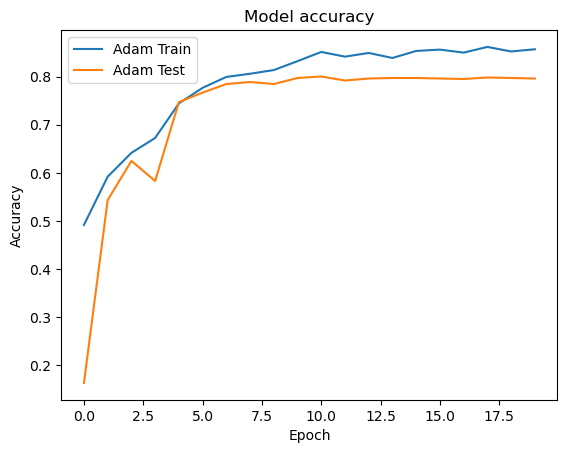

In [30]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

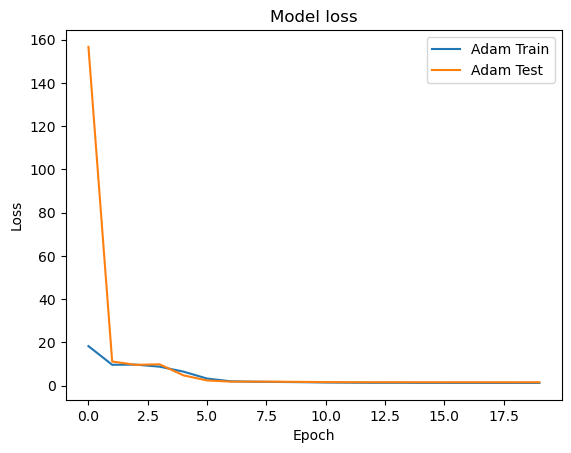

In [31]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Learning rate

In [32]:
learning_rates_used = adaptive_lr_scheduler.learning_rates
print("Learning rates per epoch:", learning_rates_used)

Learning rates per epoch: [0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001, 1e-05, 1e-05, 1e-05, 1e-05, 1.0000000000000002e-06, 1e-06, 1e-06, 1e-06, 1e-06]


## Saving lr

In [33]:
import pickle

# Save learning rates list
with open('learning_rates_used.pkl', 'wb') as f:
    pickle.dump(learning_rates_used, f)

## Loading lr

In [ ]:
import pickle

# Load learning rates list
with open(r'XNAPproject-grup07\models\histories\learning_rates_used.pkl', 'rb') as f:
    learning_rates_used = pickle.load(f)

## Without loading

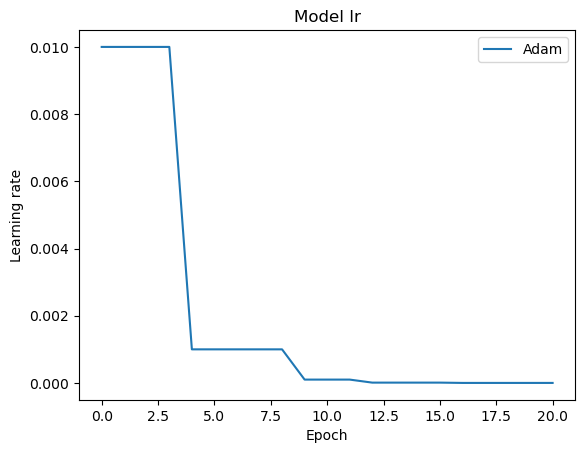

In [34]:
plt.plot(learning_rates_used, label = "Adam")

plt.title('Model lr')
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save model

In [35]:
model_adam.save("model_adam_lr_grad_acc.keras")

# Predict the output 🔮 🎩

In [36]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

3313

In [37]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

In [38]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

## Adam

In [39]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3313/3313 ━━━━━━━━━━━━━━━━━━━━ 337s 101ms/step


In [ ]:
print(len(pred_adam),"\n",pred_adam)

10113 
 [[8.04727257e-04 4.04767739e-03 3.89879569e-04 ... 5.35861496e-03
  2.05516844e-05 8.24720628e-05]
 [1.09930761e-05 7.13876216e-04 1.25340803e-03 ... 9.94388130e-04
  3.79198559e-06 2.49061541e-05]
 [1.51381202e-04 8.74841469e-04 3.75820309e-05 ... 6.74502342e-04
  4.13899579e-06 4.49073195e-05]
 ...
 [1.39237553e-01 1.04452565e-01 7.60575582e-04 ... 7.46746222e-03
  5.34233376e-02 2.08907411e-03]
 [1.77956317e-04 6.74847901e-01 6.08954020e-02 ... 8.75055033e-04
  1.24265872e-01 2.19740643e-04]
 [4.03708927e-02 1.24865668e-02 5.25613362e-03 ... 1.17507484e-02
  2.11067483e-01 1.39211980e-03]]


In [40]:
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

In [41]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

6626 
 [2 2 0 ... 2 9 5]
it has values ranging from  0 ...to... 9
********************
class_indices
********************
 {'Camille Pissarro': 0, 'Vincent van Gogh': 1, 'Theophile Steinlen': 2, 'Pierre-Auguste Renoir': 3, 'Boris Kustodiev': 4, 'Pyotr Konchalovsky': 5, 'Gustave Dore': 6, 'Edgar Degas': 7, 'Camille Corot': 8, 'Eugene Boudin': 9} 

********************
labels
********************
 {0: 'Camille Pissarro', 1: 'Vincent van Gogh', 2: 'Theophile Steinlen', 3: 'Pierre-Auguste Renoir', 4: 'Boris Kustodiev', 5: 'Pyotr Konchalovsky', 6: 'Gustave Dore', 7: 'Edgar Degas', 8: 'Camille Corot', 9: 'Eugene Boudin'} 

********************
predictions has 6626 values that look like 'Theophile Steinlen' which is the first prediction and corresponds to this index of the classes: 2


In [52]:
results_adam.head()

,Filename,Predictions,Real Values
0,836.jpg,Theophile Steinlen,kiri nichol
1,49823.jpg,Theophile Steinlen,Hiroshige
2,32996.jpg,Camille Pissarro,Paul Serusier
3,77203.jpg,Theophile Steinlen,Hiroshige
4,75956.jpg,Gustave Dore,Jan Matejko


In [ ]:
len(training_set_artists)

10

In [42]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists
201 / 241 = 0.8340
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6385
0 / 6385 = 0.0000
test accuracy on new images
201 / 6626 = 0.0303


## Confusion Matrix

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as pl

# already executed
# pred_adam = model_adam.predict(test_gen)
# predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

index_dict = {0: 'Camille Pissarro', 1: 'Vincent van Gogh', 2: 'Theophile Steinlen', 3: 'Pierre-Auguste Renoir', 4: 'Boris Kustodiev', 5: 'Pyotr Konchalovsky', 6: 'Gustave Dore', 7: 'Edgar Degas', 8: 'Camille Corot', 9: 'Eugene Boudin'}

test_true_labels = results_adam['Real Values']
test_true_labels = test_true_labels.astype(str)
test_pred_labels = predicted_class_indices_adam.astype(str)


In [89]:
def replace_name_with_index(index, index_dict):
    return index_dict[int(index)]

indexed_array = np.array([replace_name_with_index(index, index_dict) for index in test_pred_labels])
print(indexed_array)

['Theophile Steinlen' 'Theophile Steinlen' 'Camille Pissarro' ...
 'Theophile Steinlen' 'Eugene Boudin' 'Pyotr Konchalovsky']


In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_true_labels, indexed_array, labels=training_set_artists + ['Unknown'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=training_set_artists + ['Unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [45]:
# IT DOESN'T WORK
accuracies_per_painter = {painter: [] for painter in training_set_artists}

# true_labels = valid_gens[0].classes
class_indices = {v: k for k, v in valid_gens[0].class_indices.items()}

for true_label, pred_label in zip(test_true_labels, predicted_class_indices_adam):
    true_painter = training_set_artists[true_label]
    pred_painter = training_set_artists[pred_label]
    accuracies_per_painter[true_painter].append(true_painter == pred_painter)

print("\nAccuracy in validation set for every painter:")
for painter, results in accuracies_per_painter.items():
    if results:
        painter_accuracy = np.mean(results)
    else:
        painter_accuracy = 0.0
    print(f'{painter}: {painter_accuracy:.2f}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 937ms/step


TypeError: list indices must be integers or slices, not str

# Mosaics

We construct a mosaic with the predicted labels and the real values.

In [ ]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


## Predictions

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/compositions/predictions_13000_images/composition_{}.png'.format(predicted_artist))


## Real values

In [ ]:
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
filtered_data = results_adam[results_adam['Real Values'].isin(training_set_artists)]
grouped_data = filtered_data.groupby('Real Values')# tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/real_values_13000_images/composition_{}.png'.format(predicted_artist))
